#CS733: Module 3 Assignment: Word Representations and Embeddings

AJ Broderick *(UIN 01244170)* \
abrod006@odu.edu \

##Import Libraries & Read Data

In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

import re
import nltk
from nltk.util import ngrams
from nltk import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from collections import Counter
from collections import defaultdict

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


___
## Part 1: Processing

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load Data

In [3]:
head = DataFrame(pd.read_csv("/content/drive/MyDrive/CS 733/Data/ted_main.csv",encoding='latin-1'))
trans = DataFrame(pd.read_csv("/content/drive/MyDrive/CS 733/Data/transcripts.csv",encoding='latin-1'))

### Text Cleaning & Tokenization

In [4]:
def token_text(text):
  for transript in text:
    transript = text.lower()
    transript = re.sub('[^a-zA-Z ]', ' ', str(transript))
    regex = re.compile('[^a-zA-Z ]')
    stop_words = set(stopwords.words('english'))
    tokens = regex.sub('', transript)
    tokens = nltk.word_tokenize(tokens)
    tokens = [word for word in tokens if word not in stop_words]
    return(tokens)

def clean_text(text):
  for transript in text:
    transript = text.lower()
    transript = re.sub('[^a-zA-Z ]', ' ', str(transript))
    regex = re.compile('[^a-zA-Z ]')
    stop_words = set(stopwords.words('english'))
    tokens = regex.sub('', transript)
    tokens = nltk.word_tokenize(tokens)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

def generate_ngrams(text, n):
    ngram_list = []
    for t in text:
        t = re.sub('[^a-zA-Z ]', '', str(t))
        regex = re.compile('[^a-zA-Z ]')
        stop_words = set(stopwords.words('english'))
        tokens = regex.sub('', t)
        tokens = tokens.lower()
        tokens = nltk.word_tokenize(tokens)
        tokens = [word for word in tokens if word not in stop_words]
        ngram_list.extend(ngrams(tokens, n))
    return ngram_list

In [5]:
trans['transcript_tokens'] = trans['transcript'].map(token_text)
trans['clean_transcript'] = trans['transcript'].map(clean_text)

### Corpus Creation

In [6]:
corpus = []
for x in trans['transcript_tokens']:
  corpus.extend(x)

corpus = list(dict.fromkeys(corpus))

print("Total words in corpus list: " + str(len(corpus)) + ' words long')

Total words in corpus list: 57288 words long


In [7]:
text_data = trans['clean_transcript'].tolist()

---
## Part 2: Building Word Embedding Models

### A. Skin-Gram Word2Vec

In [8]:
import gensim
from gensim.models import Word2Vec

model = Word2Vec(trans['transcript_tokens'], vector_size=100, window=5, min_count=1)

model.save("word2vec.model")

### B. Positive Pointwise Mutual Information (PPMI)

$ PMI(w_{1},w_{2}) = log_{2} \Bigl(\frac{p(w_{1},w_{2})}{p(w_{1})p(w_{2})}\Bigl) $

$ PPMI(w,c) = max(log_{2} \frac{P(w,c)}{P(w)P(c)},0) $

In [11]:
import math
from collections import Counter, defaultdict

def generate_ngrams(text, n):
    ngram_list = []
    for t in text:
        tokens = nltk.word_tokenize(t)
        tokens = [word for word in tokens]
        ngram_list.extend(ngrams(tokens, n))
    return ngram_list

word_freq = Counter(generate_ngrams(trans['clean_transcript'], 1))
bigram_freq = Counter(generate_ngrams(trans['clean_transcript'], 2))

total_words = len(corpus)
p_word = defaultdict(float)
p_bigram = defaultdict(float)

for word, freq in word_freq.items():
    p_word[word] = freq / total_words

total_bigrams = len(corpus) - 1
for bigram, freq in bigram_freq.items():
    p_bigram[bigram] = freq / total_bigrams

def calculate_ppmi(bigram, p_bigram, p_word):
    word1, word2 = bigram
    return max(0,math.log2(max(p_bigram[bigram], 1e-10) / (max(p_word[word1,], 1e-10) * max(p_word[word2,], 1e-10))))

ppmi = {bigram: calculate_ppmi(bigram, p_bigram, p_word) for bigram in bigram_freq}

### C. Term Frequency-Inverse Document Frequency (TF-IDF)

$ tf_{t,d} = \begin{cases} 1+log_{10} count(t,d)  \text{ if count(t,d) > 0} \\ 0 \text{ otherwise} \end{cases} $

$ idf_{t} = log_{10} \Bigl(\frac{N}{df_{t}} \Bigr) $

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(trans['clean_transcript'])

tfidf_matrix = X.toarray()

In [13]:
tfidf_df = pd.DataFrame(tfidf_matrix[:5], columns=vectorizer.get_feature_names_out())

In [14]:
tfidf_dict = dict(zip(vectorizer.get_feature_names_out(), X.toarray().sum(axis=0)))

---
## Part 3. Word Pair Similarity Comparison

### 1.Select Word Pairs

In [16]:
def generate_ngrams(texts, n):
    ngram_list = []
    for text in texts:
        text = re.sub('[^a-zA-Z ]', '', str(text))
        regex = re.compile('[^a-zA-Z ]')
        stop_words = set(stopwords.words('english'))
        tokens = regex.sub('', text)
        tokens = tokens.lower()
        tokens = nltk.word_tokenize(tokens)
        tokens = [word for word in tokens if word not in stop_words]
        ngram_list.extend(ngrams(tokens, n))
    return ngram_list

In [80]:
df = pd.merge(head, trans, on='url', how = 'inner')
df = df[['tags','url','clean_transcript']]

In [18]:
topic_tags = generate_ngrams(df['tags'],1)
tag_freq = Counter(topic_tags)
tag_freq.most_common(15)

[(('technology',), 712),
 (('science',), 654),
 (('global',), 552),
 (('design',), 514),
 (('issues',), 490),
 (('health',), 487),
 (('culture',), 476),
 (('tedx',), 418),
 (('business',), 364),
 (('change',), 302),
 (('entertainment',), 287),
 (('art',), 283),
 (('social',), 266),
 (('ted',), 249),
 (('biology',), 227)]

In [19]:
topics = ['science','health','biology']

filtered_transripts = pd.DataFrame(columns=['tags','url','clean_transcript'])

for selection in topics:
  tmp = pd.DataFrame(columns=['tags','url','clean_transcript'])
  tmp[['tags','url','clean_transcript']] = df[['tags','url','clean_transcript']][df['tags'].str.contains(selection)]
  filtered_transripts = pd.concat([filtered_transripts, tmp])

filtered_transripts = filtered_transripts.drop_duplicates()

In [20]:
bigrams = generate_ngrams(filtered_transripts['clean_transcript'][filtered_transripts['tags'].str.contains('health')], 1)
bigram_freq = Counter(bigrams)
bigram_freq.most_common(15)

[(('people',), 2669),
 (('one',), 2575),
 (('like',), 2262),
 (('going',), 1703),
 (('know',), 1666),
 (('get',), 1602),
 (('see',), 1555),
 (('us',), 1486),
 (('think',), 1484),
 (('would',), 1395),
 (('really',), 1391),
 (('time',), 1348),
 (('years',), 1277),
 (('actually',), 1242),
 (('could',), 1231)]

In [21]:
word_pairs = [
    ("climate", "solar"),
    ("million", "humans"),
    ("health", "change"),
    ("cancer", "system")
]

distinct_words = ["climate", "solar", "million", "humans", "health", "change","cancer", "system"]

### 2.Calculate Similarity

$$ cos \theta = \frac{A \cdot B}{|A|\text{ }|B|} $$

#### Word2Vec

In [73]:
# Choose your word pairs
word_pairs_list = [
    ("system", "climate"),
    ("system", "solar"),
    ("system", "million"),
    ("system", "humans"),
    ("system", "health"),
    ("system", "change"),
    ("system", "cancer"),
    ("system", "system")
    ]

In [58]:
for pair in word_pairs_list:
  similarity = model.wv.similarity(pair[0],pair[1])
  print(f"Cosine similarity between '{pair[0]}' and '{pair[1]}': {similarity}")

Cosine similarity between 'system' and 'climate': 0.27550962567329407
Cosine similarity between 'system' and 'solar': 0.6369132399559021
Cosine similarity between 'system' and 'million': 0.016655219718813896
Cosine similarity between 'system' and 'humans': 0.23178845643997192
Cosine similarity between 'system' and 'health': 0.4968419075012207
Cosine similarity between 'system' and 'change': 0.10416172444820404
Cosine similarity between 'system' and 'cancer': 0.28118473291397095
Cosine similarity between 'system' and 'system': 1.0


#### PPMI

In [74]:
for pair in word_pairs_list:
  def process_record(record):
    try:
      result = ppmi[(pair[0],pair[1])]
    except Exception as e:
      0
    else:
      return result
  similarity = process_record(pair)
  similarity = 0 if similarity is None else similarity
  print(f"Pair similarity between '{pair[0]}' and '{pair[1]}': {similarity}")

Pair similarity between 'system' and 'climate': 0
Pair similarity between 'system' and 'solar': 0
Pair similarity between 'system' and 'million': 0
Pair similarity between 'system' and 'humans': 0
Pair similarity between 'system' and 'health': 0
Pair similarity between 'system' and 'change': 0
Pair similarity between 'system' and 'cancer': 0
Pair similarity between 'system' and 'system': 0


#### TF-IDF

In [26]:
feature_names = vectorizer.get_feature_names_out()

for pair in word_pairs_list:
    word1_index = feature_names.tolist().index(pair[0])
    word2_index = feature_names.tolist().index(pair[1])

    word1_vector = np.array(tfidf_matrix[:, word1_index])
    word2_vector = np.array(tfidf_matrix[:, word2_index])

    word1_vector = word1_vector.reshape(1,-1)
    word2_vector = word2_vector.reshape(1,-1)

    similarity = cosine_similarity(word1_vector, word2_vector)

    print(f"Cosine similarity between '{pair[0]}' and '{pair[1]}': {similarity}")

Cosine similarity between 'system' and 'climate': [[0.1439914]]
Cosine similarity between 'system' and 'solar': [[0.19197134]]
Cosine similarity between 'system' and 'million': [[0.27617843]]
Cosine similarity between 'system' and 'humans': [[0.16022974]]
Cosine similarity between 'system' and 'health': [[0.21461408]]
Cosine similarity between 'system' and 'change': [[0.26335587]]
Cosine similarity between 'system' and 'cancer': [[0.10638881]]
Cosine similarity between 'system' and 'system': [[1.]]


## Part 4: Visualization and Analysis

### 1.Heatmap Visualization

In [27]:
w2v_scores = [
    [1, 0.289, 0.171, 0.256, 0.331, 0.692, 0.133, 0.304],
    [0.289, 1, 0.252, 0.2, 0.222, 0.184, 0.17, 0.627],
    [0.171, 0.252, 1, 0.202, 0.17, 0.089, 0.165, 0.005],
    [0.256, 0.2, 0.202, 1, 0.132, 0.262, 0.276, 0.208],
    [0.331, 0.222, 0.17, 0.132, 1, 0.236, 0.452, 0.472],
    [0.692, 0.184, 0.089, 0.262, 0.236, 1, 0.151, 0.304],
    [0.133, 0.17, 0.165, 0.276, 0.452, 0.151, 1, 0.317],
    [0.304, 0.627, 0.005, 0.208, 0.472, 0.304, 0.317, 1]
]

w2v_df = pd.DataFrame(w2v_scores, columns= distinct_words, index=distinct_words)

In [77]:
ppmi_scores = [
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [3.058, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2.527, 0, 0, 0, 0, 0, 0]

]

ppmi_df = pd.DataFrame(ppmi_scores, columns= distinct_words, index=distinct_words)

In [78]:
tfidf_scores = [
    [1, 0.129, 0.145, 0.066, 0.065, 0.419, 0.011, 0.144],
    [0.129, 1, 0.103, 0.068, 0.035, 0.094, 0.005, 0.192],
    [0.145, 0.103, 1, 0.16, 0.2, 0.294, 0.071, 0.276],
    [0.066, 0.068, 0.16, 1, 0.075, 0.158, 0.039, 0.16],
    [0.065, 0.035, 0.2, 0.075, 1, 0.192, 0.135, 0.215],
    [0.419, 0.094, 0.294, 0.158, 0.192, 1, 0.082, 0.263],
    [0.011, 0.005, 0.071, 0.039, 0.135, 0.082, 1, 0.106],
    [0.144, 0.192, 0.276, 0.16, 0.215, 0.263, 0.106, 1]
]

tfidf_df = pd.DataFrame(tfidf_scores, columns= distinct_words, index=distinct_words)


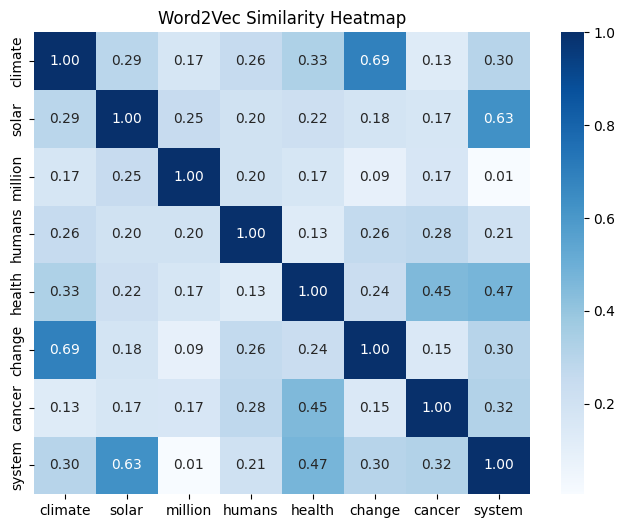

In [29]:
plt.figure(figsize=(8, 6))
sns.heatmap(w2v_df, annot=True, cmap='Blues', fmt='.2f', cbar=True)
plt.title('Word2Vec Similarity Heatmap')
plt.show()

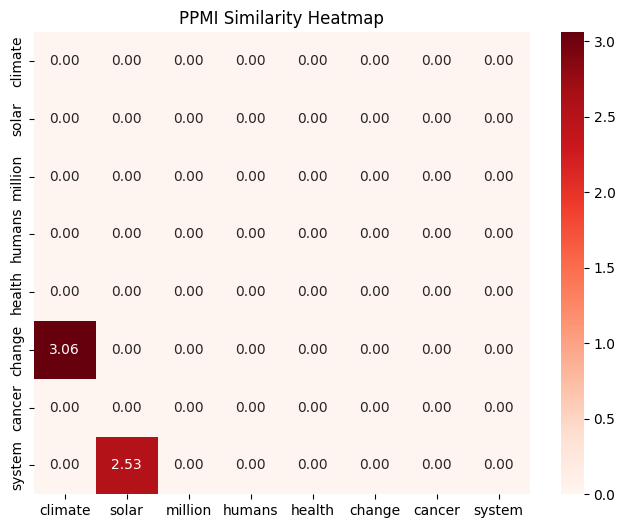

In [79]:
plt.figure(figsize=(8, 6))
sns.heatmap(ppmi_df, annot=True, cmap='Reds', fmt='.2f', cbar=True)
plt.title('PPMI Similarity Heatmap')
plt.show()

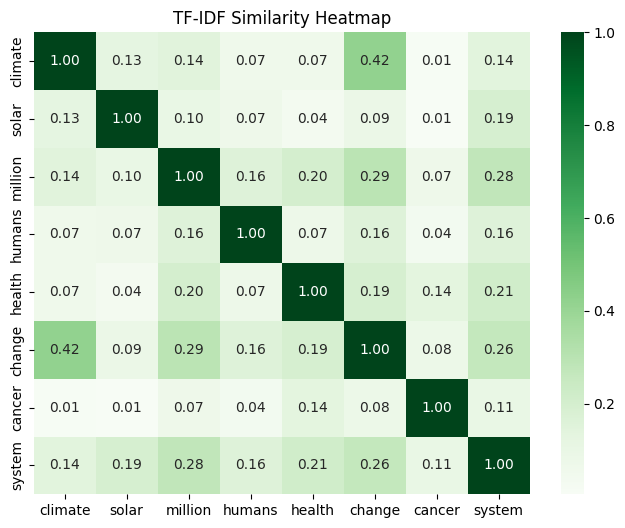

In [30]:
plt.figure(figsize=(8, 6))
sns.heatmap(tfidf_df, annot=True, cmap='Greens', fmt='.2f', cbar=True)
plt.title('TF-IDF Similarity Heatmap')
plt.show()

### 2.Analysis

&emsp; When looking at the output of the three different models, the **Word2Vec** model seemed the best in capturing the meaningful word relationships. This is determined by the overall higher cosine similarity  scores from the different word pairs. \
&emsp; It might have been from the way that it was coded, but the PPMI model did not do a very good job at finding meaningful word relationships. This could be due to a handful of things with the first being the lack of co-occurrence. When building the model, the script would continue to crash the code when trying to build the rolling window for finding co-occurrence instances. This resulted in the word pairs needing to be occur in the text exactly (for example ('climate' , 'change') had but ('change' ,'climate') did not. The other reason for the poor word relationship output is that the value from the PPMI comes from a single value, where the other two models used cosine similarity to determine the relationship. Because of this, the PPMI model is excluded from any further analysis. \
&emsp; While both are used to represent text data, the key difference between Word2Vec and TF-IDF is that Word2Vec is a neural network-based method that captures semantic relationships between words by considering their context within a corpus. This contrasts to TF-IDF as it is a statistical measure that simply calculates the importance of a word based on its frequency within a document and its rarity across the entire document collection, without considering context.